# Prototyping a New Chianti Ion Object
Trying to come up with a stripped down version of the ChiantiPy `ion` object. It needs to:

* Calculate ionization equilibrium
* Calculate emissivity

In [1]:
import os
import warnings
import logging
import copy
import cProfile
import itertools

import numpy as np
import scipy.interpolate
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import ChiantiPy.core as ch
import ChiantiPy.tools as ch_tools

%matplotlib inline

 using cli
 using CLI for selections
 reading chiantirc file


In [2]:
def collect_points(x,y):
    """
    Using two lists, where the first has repeated entries, sum the corresponding entries
    in the repeated list for each unique entry in the first list.

    Parameters
    ----------
    x : `list`
    y : `list`
    """
    unique_sorted_x = np.array(sorted(set(x)))
    summed_sorted_y = np.array([np.array([g[1] for g in grp]).sum(axis=0) \
            for lvl,grp in itertools.groupby(sorted(zip(x,y),key=lambda k:k[0]),lambda k:k[0])])
    return unique_sorted_x,summed_sorted_y

In [3]:
class ChiantiIon(object):
    """
    Stripped down ChiantiPy ion object for doing emissivity and ionization equilibrium calculations
    """
    
    @u.quantity_input(temperature=u.K,electron_density=u.cm**(-3))
    def __init__(self,ion_name,temperature,electron_density,setup=True,**kwargs):
        self.logger = logging.getLogger(name=type(self).__name__)
        if ion_name not in ch_tools.data.MasterList:
            raise ValueError('{} not in CHIANTI database'.format(ion_name))
        self.meta = ch_tools.util.convertName(ion_name)
        self.meta['name'] = ion_name
        self.meta['spectroscopic_name'] = ch_tools.util.zion2spectroscopic(self.meta['Z'],self.meta['Ion'])
        self.meta['rcparams'] = ch_tools.data.Defaults.copy()
        # read ion data from CHIANTI database
        if setup:
            self._read_chianti_db(**kwargs)
        # check and set temperature and density
        #temperature = np.array(temperature)
        #electron_density = np.array(electron_density)
        if temperature.size != electron_density.size:
            if temperature.size == 1:
                temperature = np.tile(temperature,len(electron_density))
            elif electron_density.size == 1:
                electron_density = np.tile(electron_density,len(temperature))
            else:
                raise ValueError('Temperature and density must be equal-sized arrays if neither is a scalar.')
        self.temperature = temperature
        self.electron_density = electron_density
        self.proton_density = electron_density*self._calculate_proton_density()
        
    def _read_chianti_db(self,**kwargs):
        """Read files from CHIANTI database for specified ion"""
        _tmp = ch_tools.io.abundanceRead(abundancename=self.meta['rcparams']['abundfile'])
        self.abundance = _tmp['abundance'][self.meta['Z']-1]
        self.meta['abundance_filename'] = _tmp['abundancename']
        self._elvlc = ch_tools.io.elvlcRead(self.meta['name'])
        self._wgfa = ch_tools.io.wgfaRead(self.meta['name'])
        _tmp = ch_tools.io.scupsRead(self.meta['name'])
        #FIXME: These warnings should really go in the respective reader functions
        if 'file not found' not in _tmp:
            self._scups = _tmp.copy()
            n_levels_scups = np.max(self._scups['lvl2'])
        else:
            warnings.warn('{} not found'.format(_tmp['file not found']))
            n_levels_scups = 1e+300
        _tmp = ch_tools.io.splupsRead(self.meta['name'],filetype='psplups')
        if 'file not found' not in _tmp:
            self._psplups = _tmp.copy()
        else:
            warnings.warn('{} not found'.format(_tmp['file not found']))
        self.n_levels = np.min([np.max(self._elvlc['lvl']),np.max(self._wgfa['lvl2']),n_levels_scups])
        
    def _calculate_proton_density(self):
        """Calculate proton density to electron density ratio from Eq. 7 of Young et al. (2003)"""
        _tmp_ioneq = ch_tools.io.ioneqRead(ioneqname=self.meta['rcparams']['ioneqfile'])
        _tmp_abundance = ch_tools.io.abundanceRead(abundancename=self.meta['rcparams']['abundfile'])
        abundance = _tmp_abundance['abundance'][_tmp_abundance['abundance']>0]
        
        denominator = np.zeros(len(_tmp_ioneq['ioneqTemperature']))
        for i in range(len(abundance)):
            for z in range(1,i+2):
                denominator += z*_tmp_ioneq['ioneqAll'][i,z,:]*abundance[i]
                
        p2eratio = abundance[0]*_tmp_ioneq['ioneqAll'][0,1,:]/denominator
        f_interp = scipy.interpolate.interp1d(np.log10(_tmp_ioneq['ioneqTemperature']),p2eratio,kind='cubic')
        return f_interp(np.log10(self.temperature.value))
        
    def _descale_collision_strengths(self,x,y,energy_ratio,c,bt_type):
        """Apply descaling procedure of BT92 to scaled thermally averaged collision
        strengths"""
        nots = scipy.interpolate.splrep(x,y,s=0)
        if bt_type==1:
            x_new = 1.0 - np.log(c)/np.log(energy_ratio + c)
            upsilon = scipy.interpolate.splev(x_new,nots,der=0)*np.log(energy_ratio + np.e)
        elif bt_type==2:
            x_new = energy_ratio/(energy_ratio + c)
            upsilon = scipy.interpolate.splev(x_new,nots,der=0)
        elif bt_type==3:
            x_new = energy_ratio/(energy_ratio + c)
            upsilon = scipy.interpolate.splev(x_new,nots,der=0)/(energy_ratio + 1.0)
        elif bt_type==4:
            x_new = 1.0 - np.log(c)/np.log(energy_ratio + c)
            upsilon = scipy.interpolate.splev(x_new,nots,der=0)*np.log(energy_ratio + c)
        elif bt_type==6:
            x_new = energy_ratio/(energy_ratio + c)
            upsilon = 10**scipy.interpolate.splev(x_new,nots,der=0)
        else:
            raise ValueError('Unrecognized BT92 scaling option.')
            
        return upsilon
        
    def _calculate_collision_strengths(self,protons=False):
        """Calculate collision strengths and excitation and de-excitation rates."""
        if protons:
            collision_data = self._psplups
            scups_key = 'splups'
            collision_data['btemp'] = [np.linspace(0,1,n_spline) for n_spline in collision_data['nspl']]
        else:
            collision_data = self._scups
            scups_key = 'bscups'
        energy_ratios = np.outer((collision_data['de']*u.Ry).to(u.erg),1.0/(self.temperature*const.k_B.cgs))
        upsilon = [self._descale_collision_strengths(x,y,er,c,btt) for x,y,er,c,btt in zip(collision_data['btemp'],
                                                                                      collision_data[scups_key],
                                                                                      1.0/energy_ratios,
                                                                                      collision_data['cups'],
                                                                                      collision_data['ttype'])]
        upsilon = np.array(upsilon)
        upsilon = np.where(upsilon>0.,upsilon,0.0)
        #calculate weights
        lower_weights = np.array([self._elvlc['mult'][self._elvlc['lvl'].index(lvl)] for lvl in collision_data['lvl1']])
        upper_weights = np.array([self._elvlc['mult'][self._elvlc['lvl'].index(lvl)] for lvl in collision_data['lvl2']])
        # modified transition energies
        _tmp_level_energies = list(np.where(np.array(self._elvlc['eryd'])>=0,
                                 np.array(self._elvlc['eryd']),np.array(self._elvlc['erydth'])))
        _tmp_transition_energies = np.array([_tmp_level_energies[self._elvlc['lvl'].index(l2)] \
                                    - _tmp_level_energies[self._elvlc['lvl'].index(l1)] \
                                    for l1,l2 in zip(collision_data['lvl1'],collision_data['lvl2'])])*u.Ry.to(u.erg)
        energy_ratios = np.outer(_tmp_transition_energies,1.0/(self.temperature*const.k_B.cgs))
        #calculate excitation and deexcitation rates
        _rate_factor = 2.172e-8*np.sqrt((13.6*u.eV).to(u.erg)/(self.temperature*const.k_B.cgs))*upsilon
        excitation_rate = ((np.exp(-energy_ratios)*_rate_factor).T*1.0/lower_weights).T
        deexcitation_rate = (_rate_factor.T*1.0/upper_weights).T
        return upsilon,excitation_rate,deexcitation_rate
    
    def _calculate_level_populations(self):
        upsilon,excitation_rate,deexcitation_rate = self._calculate_collision_strengths()
        # create excitation/deexcitation rate sums for broadcasting
        l1_indices_electron,_electron_ex_broadcast = collect_points(self._scups['lvl1'],excitation_rate)
        l2_indices_electron,_electron_dex_broadcast = collect_points(self._scups['lvl2'],deexcitation_rate)
        
        # account for protons if the file exists
        if hasattr(self,'_psplups'):
            upsilon_proton,excitation_rate_proton,deexcitation_rate_proton = self._calculate_collision_strengths(protons=True)
            # create excitation/deexcitation rate sums for broadcasting
            l1_indices_proton,_proton_ex_broadcast = collect_points(self._psplups['lvl1'],excitation_rate_proton)
            l2_indices_proton,_proton_dex_broadcast = collect_points(self._psplups['lvl2'],deexcitation_rate_proton)
        
        process_matrix = np.zeros([self.n_levels,self.n_levels])
        # add spontaneous emission, TODO: correction for recombination and ionization
        process_matrix[np.array(self._wgfa['lvl1'])-1,np.array(self._wgfa['lvl2'])-1] += self._wgfa['avalue']
        # sum all of the level 2 Avalues to broadcast
        _wgfa_indices,_wgfa_broadcasts = collect_points(self._wgfa['lvl2'],self._wgfa['avalue'])
        process_matrix[_wgfa_indices-1,
                       _wgfa_indices-1] -= _wgfa_broadcasts
        #TODO: add photoexcitation and stimulated emission
        
        #b vector used for inversion later on
        b = np.zeros(process_matrix.shape[0])
        b[-1] = 1.0
        #preallocate memory for level populations
        populations = np.zeros([self.n_levels,len(self.temperature)])
        for i,(nel,npr,T) in enumerate(zip(self.electron_density,self.proton_density,self.temperature)):
            _tmp = np.copy(process_matrix)
            # excitation and de-excitation by electrons
            _tmp[np.array(self._scups['lvl1'])-1,np.array(self._scups['lvl2'])-1] += nel*deexcitation_rate[:,i]
            _tmp[np.array(self._scups['lvl2'])-1,np.array(self._scups['lvl1'])-1] += nel*excitation_rate[:,i]
            # broadcast summed excitation rates for level 1 
            _tmp[l1_indices_electron-1,l1_indices_electron-1] -= nel*_electron_ex_broadcast[:,i]
            # sum deexcitation rates for level 2 to broadcast
            _tmp[l2_indices_electron-1,l2_indices_electron-1] -= nel*_electron_dex_broadcast[:,i]
            # excitation and de-excitation by protons
            if hasattr(self,'_psplups'):
                _tmp[np.array(self._psplups['lvl1'])-1,
                     np.array(self._psplups['lvl2'])-1] += npr*deexcitation_rate_proton[:,i]
                _tmp[np.array(self._psplups['lvl2'])-1,
                     np.array(self._psplups['lvl1'])-1] += npr*excitation_rate_proton[:,i]
                # sum excitation rates for level 1 broadcast
                _tmp[l1_indices_proton-1,l1_indices_proton-1] -= npr*_proton_ex_broadcast[:,i]
                # sum deexcitation rates for level 2 broadcast
                _tmp[l2_indices_proton-1,l2_indices_proton-1] -= npr*_proton_dex_broadcast[:,i]
            # TODO: add effects from ionization and recombination
            # invert
            _tmp[-1,:] = np.ones(_tmp.shape[0])
            populations[:,i] = np.linalg.solve(_tmp,b)
            
        return populations
            
    def calculate_emissivity(self):
        """Calculate the emissivity for each transition"""
        #find where wavelength is nonzero
        wavelength = np.fabs(np.array(self._wgfa['wvl']))*u.angstrom
        lvl2 = np.array(self._wgfa['lvl2'])
        avalues = np.array(self._wgfa['avalue'])/u.s
        # exclude two-photon decays that are denoted by 0 wavelength
        lvl2 = lvl2[wavelength!=0]
        avalues = avalues[wavelength!=0]
        wavelength = wavelength[wavelength!=0]
        # set energy conversion factor
        if self.meta['rcparams']['flux'] == 'energy':
            energy_factor = (const.h*const.c).to(u.erg*u.angstrom)/(wavelength)
        else:
            self.logger.info('Expressing emissivity in units of photons')
            energy_factor = 1.0*u.photon
        # calculate level populations
        level_populations = self._calculate_level_populations()
        # calculate emissivity
        emissivity = ((level_populations[lvl2-1,:]).T*avalues*energy_factor).T
        return emissivity
    
    def calculate_ionization_equilibrium(self):
        """Calculate ionization equilibrium."""
        _tmp_ioneq = ch_tools.io.ioneqRead(ioneqname=self.meta['rcparams']['ioneqfile'])
        match_indices = np.where(
            (self.temperature>=_tmp_ioneq['ioneqTemperature'].min()) & \
            (self.temperature<=_tmp_ioneq['ioneqTemperature'].max()))[0]
        if len(match_indices) != len(self.temperature):
            warnings.warn('''Temperature out of ionization equilibrium range.
                            Those temperatures will have zero fractional ionization.''')
        fractional_ionization = np.zeros(len(self.temperature))
        f_interp = scipy.interpolate.interp1d(np.log10(_tmp_ioneq['ioneqTemperature']),
                                              _tmp_ioneq['ioneqAll'][self.meta['Z']-1,
                                                                     self.meta['Ion']-1+self.meta['Dielectronic'],:],
                                             kind='cubic')
        fractional_ionization[match_indices] = f_interp(np.log10(self.temperature[match_indices]))
        fractional_ionization[fractional_ionization<0] = 0.0
        return fractional_ionization

In [8]:
density_mesh,temperature_mesh = np.meshgrid(np.logspace(8,11,100),np.logspace(5,8,100))
foo = ChiantiIon('fe_16',np.ravel(temperature_mesh)*u.K,np.ravel(density_mesh)/u.cm**3,setup=True)

/opt/anaconda3/envs/chiantipy/lib/python2.7/site-packages/ipykernel/__main__.py:51: UserWarning: /usr/local/ssw/packages/chianti/dbase/fe/fe_16/fe_16.psplups not found


In [9]:
%%prun
pop = foo._calculate_level_populations()

In [20]:
emiss = foo.calculate_emissivity()

In [21]:
foo_chpy = ch.ion(foo.meta['name'],temperature=foo.temperature,eDensity=foo.electron_density)

In [22]:
foo_chpy.populate(popCorrect=0)

In [23]:
foo_chpy.emiss()

(1e-30, 1e-09)

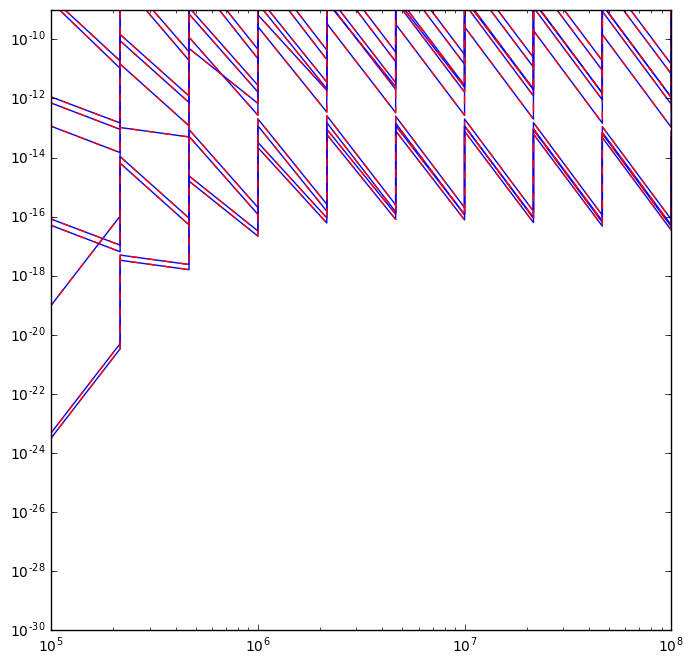

In [24]:
plt.figure(figsize=(8,8))
for i in range(10):
    plt.plot(foo.temperature,emiss[i,:],'b')
    plt.plot(foo_chpy.Temperature,4*np.pi*foo_chpy.Emiss['emiss'][i,:],'--r')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,1e-9])

In [ ]:
emiss.shape